In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [ ]:
# 흑백 이미지를 컬러로 변경( = 1채널을 3채널로 변경) 흑백이 컬러로 바뀌지는 않음
# 추후에 컬러이미지를 넣을 경우 결과가 컬러로 나올수 있도록 작업해주는 것
# 노이즈 추가하기 전에 작업함

In [7]:
np.shape(x_train[0])

(28, 28)

In [11]:
from skimage import color
np.shape(color.gray2rgb(x_train[0]))
# 채널을 변경함 1 -> 3

(28, 28, 3)

In [12]:
# 노이즈 추가하기 전에 작업함
# 1채널에서 3채널로 변경
from skimage import color
x_train_color = [color.gray2rgb(x) for x in x_train]
x_test_color = [color.gray2rgb(x) for x in x_test]


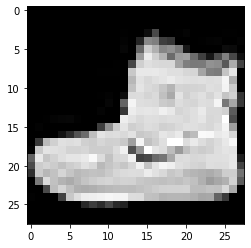

In [13]:
plt.imshow(x_train_color[0])

In [16]:
np.shape(x_train_color)

(60000, 28, 28, 3)

In [17]:
# noise는 오디오 할때 백색잡음(생활잡음) 이라고 해서 중요한 요소임
# 그레이스케일(흑백)일때는 shape=x_train.shape 해도 28*28 이지만
# 컬러일때는 28*28*3 이되어 복잡해짐
# 지금은 흑백자료로 비교 함
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

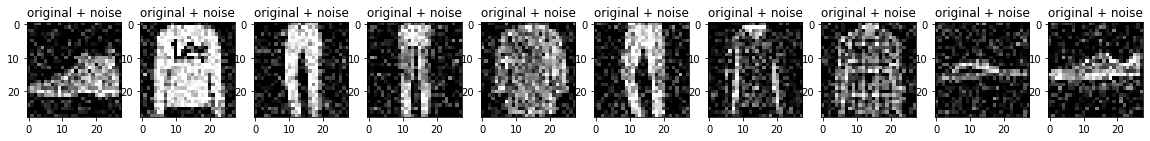

In [4]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

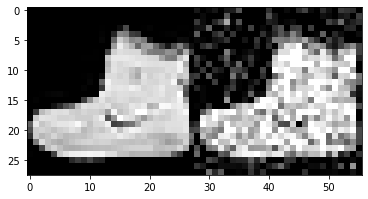

In [5]:
#-----
plt.imshow(np.concatenate([x_train[0], x_train_noisy[0]], axis=1))
plt.show()

In [6]:
# 스케일링이 잘 되어 있는 자료 확인
x_train.min(), x_train.max()
# 잘 되어 있음

(0.0, 1.0)

In [19]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model

inputs = Input(shape=(28, 28,1)) # 흑백일때는 (28,28,1) 컬러일때는 (28,28,3)
x = Conv2D(32, 3, 2, activation='relu', padding='same')(inputs)
#인풋값에 32dense층, ?, 스ㅌ값 2
x = Conv2D(64, 3, 2, activation='relu', padding='same')(x)
x = Flatten()(x)
latent = Dense(10)(x)
x = Dense(7 * 7 * 64)(latent)

x = Reshape((7, 7, 64))(x)

x = Conv2DTranspose(64, 3, 2, activation='relu', padding='same')(x)
x = Conv2DTranspose(32, 3, 2, activation='relu', padding='same')(x)
x = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

model = Model(inputs, x)


In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                31370     
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              34496     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0   

In [21]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
hist = model.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=5, verbose=2)


Epoch 1/5
1875/1875 - 107s - loss: 0.0225 - accuracy: 0.5042 - val_loss: 0.0158 - val_accuracy: 0.5051
Epoch 2/5
1875/1875 - 106s - loss: 0.0149 - accuracy: 0.5071 - val_loss: 0.0146 - val_accuracy: 0.5048
Epoch 3/5
1875/1875 - 108s - loss: 0.0141 - accuracy: 0.5074 - val_loss: 0.0141 - val_accuracy: 0.5055
Epoch 4/5
1875/1875 - 104s - loss: 0.0136 - accuracy: 0.5075 - val_loss: 0.0135 - val_accuracy: 0.5053
Epoch 5/5
1875/1875 - 104s - loss: 0.0133 - accuracy: 0.5077 - val_loss: 0.0133 - val_accuracy: 0.5055


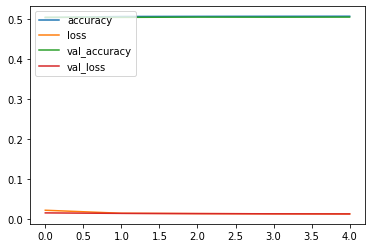

In [22]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

           y값,            x값,          예측값


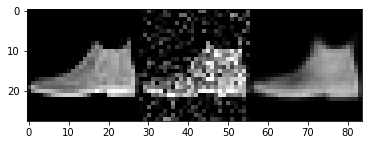

In [33]:
# test 데이터로 결과 확인
res = model.predict(x_test_noisy[0:1])

plt.imshow(np.concatenate([x_test[0], x_test_noisy[0], res[0].reshape(28,28)], axis=1))
print('           y값,            x값,          예측값')

In [ ]:
# 코랩에서 h5파일 저장후 다운받는 방법

In [29]:
model.save('Auto_mnist_noisy_model.h5')

In [30]:
from google.colab import  files
files.download('./Auto_mnist_noisy_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>